# CNN (Convolutional Neural Network)

In [31]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

Google Colab에서 실행할 경우 위 주석을 해제하고 실행하면 됨. Colab에는 pytorch가 설치되어있지 않으므로 설치 필요.

In [32]:
import torch
import torchvision
import torch.nn as nn

**torch**는 pytorch의 가장 상위에 있는 package로써 라이브러리에서 이것저것 불러오기 위해 import

**torch.nn**은 모델을 정의할 때 사용하는 Class들을 포함하고 있음.

**torchvision**은 Computer vision에서 사용하는 각종 테크닉들을 torch와 연동하여 구현한 라이브러리.

In [33]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [34]:
import numpy as np
import datetime
import os, sys

**numpy**는 python으로 data science를 할 때 가장 기본이 되는 라이브러리 중 하나. 각종 행렬 연산에 필요한 함수들을 다수 포함하고 있음.
**datetime** 시간찍을려고...
**os, sys** os로부터 정보를 얻고 싶을 때 쓰는 라이브러리

In [35]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

**matplotlib**는 python visualization library

In [36]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU가 있다면 GPU를 통해 학습을 가속화하고, 없으면 CPU로 학습하기 위해 device를 정해준다.

**torch.cuda.is_avaliable()**은 GPU가 사용가능한지를 판단하는 함수

In [37]:
class HelloCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=10):
        super(HelloCNN, self).__init__()
        self.conv = nn.Sequential(
            # (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 64, 7, 7)
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7)
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7)
        y_ = self.fc(y_)
        return y_

### 모델 정의를 위한 코드

**nn.Module**: 뉴럴넷 구현을 위한 base class. forward, parameter 등 모델을 만들고 사용할 때 필요한 부분들이 내부적으로 구현되어 있음.

**__init__**: python class의 constructor. 필요한 멤버변수들을 초기화하고, **nn.Sequential** or **nn.ModuleList**를 이용하여 모델의 구성을 정의한다.

**forward**: 모델의 input을 받고 output을 return하는 함수.

**nn.Conv2d**: Convolutional Layer. 입력 채널과 출력 채널을 parameter로 받는다. kernel size가 3이므로 padding 1을 통해 같은 크기가 나오도록 한다.

**nn.MaxPool2d**: max pooling을 수행한다. feature map size를 줄여주는 역할.

**nn.Dropout**: Dropout. p는 drop probability

In [38]:
model = HelloCNN().to(DEVICE)

정의한 모델을 메모리에 올리는 작업.

In [39]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

**transforms** torchvision에서 제공하는 transform 함수들이 있는 패키지.

**ToTensor**는 numpy array를 torch tensor로 변환.

**Normalize**는 다음과 같이 계산함. input[channel] = (input[channel] - mean[channel]) / std[channel]

In [40]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [41]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

**datasets**에는 여러 데이터들에 대해 다운로드하고 처리하는 클래스가 내장되어 있음. [참고](https://pytorch.org/docs/stable/torchvision/datasets.html)

root 폴더에 없을 시에 download하고, 앞서 정의한 transform에 따라 전처리 된 데이터를 return함.

In [10]:
batch_size = 64

In [11]:
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=100, shuffle=False, drop_last=False)

**DataLoader**는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.

**shuffle**: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.

**drop_last**: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

In [12]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

**nn.CrossEntropyLoss**: Cross entropy를 계산하는 Loss. softmax가 내부적으로 수행된다.

**optim.Adam**: optim에는 여러 optimizer가 있고, Adam Optimizer는 대표적으로 많이 사용된다.

In [13]:
max_epoch = 5
step = 0

최대 epoch 조정

### Training

첫번째 for문: 원하는 epoch만큼 반복

두번째 for문: training datset에서 배치 사이즈 만큼씩 모두 샘플링 될 때까지 반복.

**Line 2**: MNIST dataset은 DataLoader를 통해 image와 label을 return.

**Line 4**: 각각 Device에 올린다 (GPU or CPU)

**Line 5**: 모델에 이미지를 넣고 forward propagation 한다.

**Line 7**: 결과값 y_hat과 실제 정답 y에 대한 loss를 계산한다.

**zero_grad (Line 9)**: 모델의 gradient를 0으로 초기화한다.

**backward (Line 10)**: loss를 계산하는 것까지 연결되어있는 graph를 따라 gradient를 계산한다.

**step (Line 11)**: 계산된 gradient를 모두 parameter에 적용한다.

**eval (Line 17)**: 모델을 evaluation mode로 바꿔준다 (dropout 조정, Batch normalization 조정 등)

**torch.no_grad (Line 19)**: gradient를 계산하기 위해 추적하는 수고를 하지 않음

**torch.max (Line 24)**: max value와 indices(즉, argmax)를 return.

**train (Line 29)**: evaluation mode였던 모델을 train mode로 전환

In [14]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        
        loss = criterion(y_hat, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, Loss: {}'.format(epoch, max_epoch, step, loss.item()))
        
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    y_hat = model(x) # (N, 10)
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)
                    acc += torch.sum(indices == y).item()
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(mnist_test)*100))
            print('*'*46)
            model.train()
        step += 1

Epoch: 0/5, Step: 0, Loss: 2.318506956100464
******************** Test ********************
Step: 0, Loss: 2.70082426071167, Accuracy: 10.040000000000001 %
**********************************************
Epoch: 0/5, Step: 500, Loss: 0.03119628131389618
Epoch: 1/5, Step: 1000, Loss: 0.07218557596206665
******************** Test ********************
Step: 1000, Loss: 0.010657086037099361, Accuracy: 98.33 %
**********************************************
Epoch: 1/5, Step: 1500, Loss: 0.04745262861251831
Epoch: 2/5, Step: 2000, Loss: 0.02198915183544159
******************** Test ********************
Step: 2000, Loss: 0.021296314895153046, Accuracy: 98.8 %
**********************************************
Epoch: 2/5, Step: 2500, Loss: 0.010919615626335144
Epoch: 3/5, Step: 3000, Loss: 0.0021269842982292175
******************** Test ********************
Step: 3000, Loss: 0.0012928677024319768, Accuracy: 99.0 %
**********************************************
Epoch: 3/5, Step: 3500, Loss: 0.00679259

## Test and Visualize

In [15]:
# Test
model.eval()
acc = 0.
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        loss = criterion(y_hat, y)
        _, indices = torch.max(y_hat, dim=-1)
        acc += torch.sum(indices == y).item()
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(mnist_test)*100))
print('*'*46)

******************** Test ********************
Step: 4685, Loss: 0.04823339357972145, Accuracy: 98.99 %
**********************************************


In [16]:
idx = 7777 # 0 to 9999
img, y = mnist_test[idx]
img.shape, y

(torch.Size([1, 28, 28]), tensor(5))

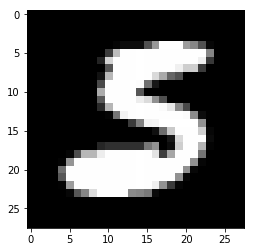

In [17]:
imshow(img[0], cmap='gray')

In [18]:
img = img.unsqueeze(dim=0)

**unsqueeze**: 원하는 dim에 차원을 높여준다. CNN forward를 위해서는 4D-Tensor여야함.

In [19]:
sample = img.to(DEVICE)
out = model(sample)
_, idx = out.max(dim=-1)
idx

tensor([5], device='cuda:0')

In [14]:
# Saving params.
torch.save(model.state_dict(), 'model.pkl')